In [1]:
import pandas as pd
total_df = pd.read_csv('./dataset/dataset_final.csv',encoding='cp949')
total_df

,식료품 고가 CV,식료품 중가 CV,식료품 저가 CV,가구 고가 CV,가구 중가 CV,가구 저가 CV,가전제품 고가 CV,가전제품 중가 CV,가전제품 저가 CV,공구류 고가 CV,...,월구매빈도,시간1,시간2,시간3,시간4,연령대,지역명,경과일,주말변화,label
0,0.133,0.454,0.646,0.0,0.0,0.790,1.000,0.967,0.0,0.0,...,1,0.0,121515.579268,98828.296078,38796.285714,9,0,9,0.154,0
1,0.200,0.390,0.414,0.0,0.0,0.203,0.847,0.557,0.0,0.0,...,3,0.0,145532.516556,127401.390476,0.000000,9,5,2,-0.193,1
2,0.539,0.347,0.405,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,7,0.0,2713.485981,4270.698225,0.000000,9,32,9,0.231,0
3,0.868,0.457,0.607,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,5,0.0,17623.431034,23321.539568,0.000000,9,13,1,0.115,0
4,0.555,0.551,0.485,0.0,0.0,0.000,0.000,0.000,1.0,0.0,...,8,0.0,21818.818182,15068.534884,0.000000,9,4,1,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18861,1.000,0.546,0.270,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,3,0.0,5544.137931,1844.718519,5982.424242,2,21,3,-0.077,1
18862,0.493,0.154,0.241,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,4,0.0,20171.615385,16449.575510,11174.120536,4,40,32,-0.039,0
18863,0.191,0.361,0.615,0.0,0.0,0.356,0.000,0.000,1.0,0.0,...,3,0.0,14246.957895,16670.564626,21440.000000,4,35,1,0.270,0
18864,1.000,0.404,0.506,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,9,0.0,34493.827160,60369.455587,17410.000000,4,19,6,0.154,0


### Feature 정보와 설명
상품분류에 관하여
- "대분류" 역할을 하는 13개의 통합카테고리 생성
- 소분류코드별 평균단가를 기준으로 통합카테고리별 고가 중가 저가로 "중분류" 역할을 하도록 함
- 자세한 사항은 ppt 참고바람  

초기 Feature (59개 독립변수와 1개 종속변수)
- 중분류별로 총매출에서 15년 매출이 차지하는 비율을 변동지수로 함.(총 39개) - null이 생기는 경우가 유일하도록 하게 하기 위함.
- 예측분기를 제외 각 분기별 매출 (7개)
- 예측분기 제외 전년동분기 매출신장율 (3개)
- 시간대별 매출 (4개)
- 주말 구매 변화 (1개)
- 특성변수로써 연령대, 지역명, 마지막구매로부터 경과일, 주구매월, 주구매시간 (5개)
- 종속변수는 타겟으로 잡은 '유의고객'(label = 0)

In [2]:
# <데이터 전처리> - 표준화로 scaling
from sklearn.preprocessing import StandardScaler
data = total_df.copy()

df = data.drop('label',axis=1)
scale = StandardScaler()
df = pd.concat([pd.DataFrame(scale.fit_transform(df), columns=df.columns),
                data.label], axis=1)
data_scaled = df

In [3]:
# <분류모델 학습/예측> - 1차 모델 설정
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

X1, X_test, y1, y_test = train_test_split(data_scaled.drop('label', axis=1),
                                 data_scaled.label, test_size=0.2, random_state=4)
                                 
# XGB와 LGBM 알고리즘은 별도의 validation 데이터가 필요.
# 트레인 데이터를 트레인과 validation데이터로 나눔
X_train, X_val, y_train, y_val = train_test_split(X1,
                                 y1, test_size=0.2, random_state=4)

rf = RandomForestClassifier(max_depth=10, min_samples_leaf=10,
                           min_samples_split=4, n_estimators=100, random_state=4)
rf.fit(X1, y1)
pr1 = rf.predict(X_test)
prob1 = rf.predict_proba(X_test)[:,1]
ac1 = accuracy_score(y_test, pr1)
prec1 = precision_score(y_test, pr1)
rec1 = recall_score(y_test, pr1)
f1_1 = f1_score(y_test, pr1)
roc1 = roc_auc_score(y_test, prob1)

lr = LogisticRegression()
lr.fit(X1, y1)
pr2 = lr.predict(X_test)
prob2 = lr.predict_proba(X_test)[:,1]
ac2 = accuracy_score(y_test, pr2)
prec2 = precision_score(y_test, pr2)
rec2 = recall_score(y_test, pr2)
f1_2 = f1_score(y_test, pr2)
roc2 = roc_auc_score(y_test, prob2)

xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
       eval_set=[(X_val,y_val)], verbose=False)
pr3 = xgb.predict(X_test)
prob3 = xgb.predict_proba(X_test)[:,1]
ac3 = accuracy_score(y_test, pr3)
prec3 = precision_score(y_test, pr3)
rec3 = recall_score(y_test, pr3)
f1_3 = f1_score(y_test, pr3)
roc3 = roc_auc_score(y_test, prob3)

lgbm = LGBMClassifier(n_estimators=400, learning_rate=0.1,max_depth=3)
lgbm.fit(X_train, y_train,early_stopping_rounds=100,eval_metric= 'logloss', 
       eval_set=[(X_val, y_val)], verbose=False)
pr4 = lgbm.predict(X_test)
prob4 = lgbm.predict_proba(X_test)[:,1]
ac4 = accuracy_score(y_test, pr4)
prec4 = precision_score(y_test, pr4)
rec4 = recall_score(y_test, pr4)
f1_4 = f1_score(y_test, pr4)
roc4 = roc_auc_score(y_test, prob4)

print(f"""
##RandomForest##
accuracy : {ac1:.3f}, precision : {prec1:.3f}, recall : {rec1:.3f}, f1 : {f1_1:.3f}, roc : {roc1:.3f}

##LogisticRegression##
accuracy : {ac2:.3f}, precision : {prec2:.3f}, recall : {rec2:.3f}, f1 : {f1_2:.3f}, roc : {roc2:.3f}

##XGBoost##
accuracy : {ac3:.3f}, precision : {prec3:.3f}, recall : {rec3:.3f}, f1 : {f1_3:.3f}, roc : {roc3:.3f}

##LightGBM##
accuracy : {ac4:.3f}, precision : {prec4:.3f}, recall : {rec4:.3f}, f1 : {f1_4:.3f}, roc : {roc4:.3f}
""")

C:\Users\chonh\anaconda3\envs\cakd5\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



##RandomForest##
accuracy : 0.723, precision : 0.709, recall : 0.705, f1 : 0.707, roc : 0.805

##LogisticRegression##
accuracy : 0.736, precision : 0.757, recall : 0.652, f1 : 0.700, roc : 0.806

##XGBoost##
accuracy : 0.779, precision : 0.764, recall : 0.772, f1 : 0.768, roc : 0.863

##LightGBM##
accuracy : 0.778, precision : 0.761, recall : 0.776, f1 : 0.768, roc : 0.863



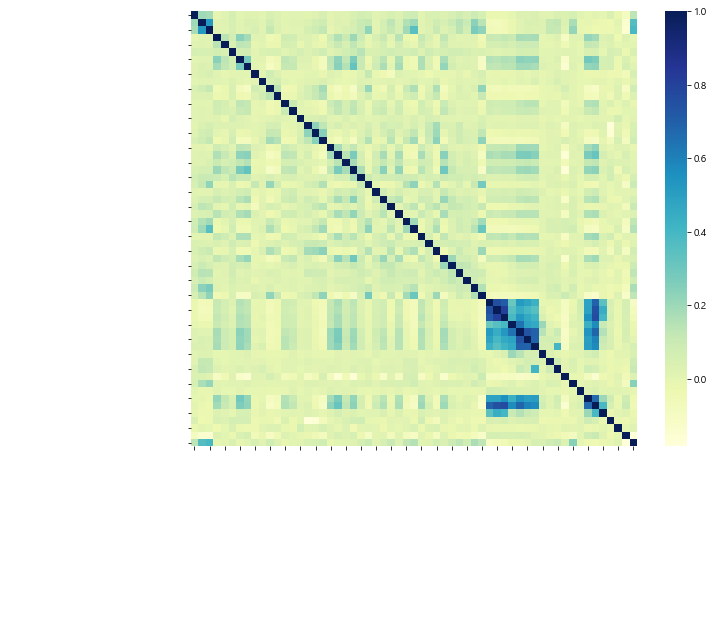

In [5]:
# <히트맵> - 변수 간 상관도를 확인
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic') # 한글폰트 설정
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 단위 설정

ax = plt.figure(figsize=(10,8)).add_subplot(111)
### 다크모드라 축색 흰색으로 함
[t.set_color('white') for t in ax.xaxis.get_ticklabels()]
[t.set_color('white') for t in ax.yaxis.get_ticklabels()]
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
###

ax = sns.heatmap(data.drop('label',axis=1).corr(), cmap='YlGnBu')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Feature 줄이기
- 정확도가 가장 높은 Xgb의 feature importance 메소드를 통해 주요 변수를 확인
- 모델 성능을 저하시키지 않는 선에서 주요 feature만 선택하도록 함

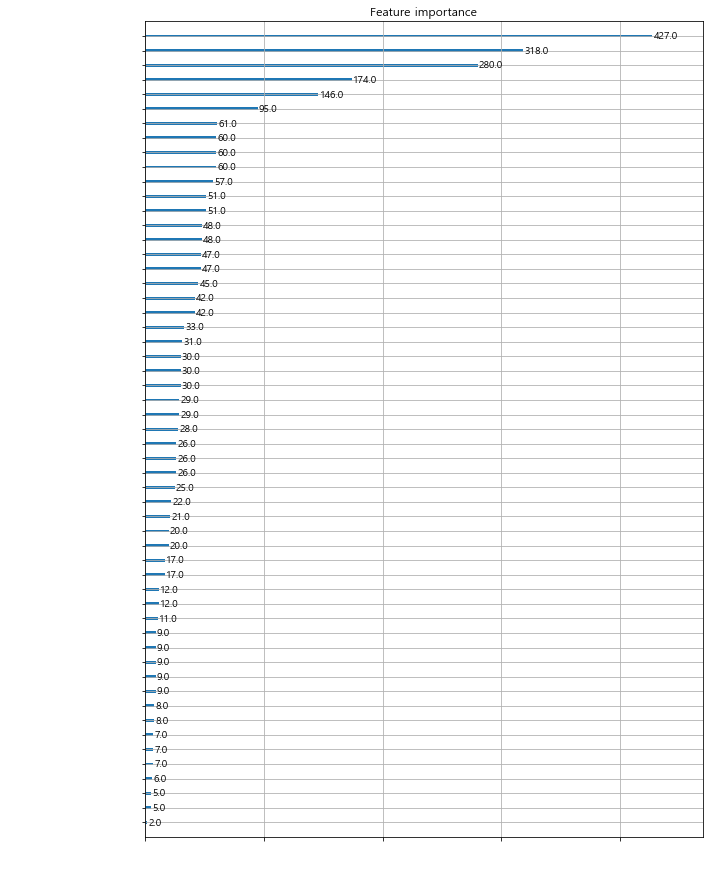

In [6]:
# <변수 중요도 - xgb>
from xgboost import plot_importance
import seaborn as sns, matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic') # 한글폰트 설정
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 단위 설정

_, ax = plt.subplots(figsize=(10,15))
### 다크모드라 축색 흰색으로 함
[t.set_color('white') for t in ax.xaxis.get_ticklabels()]
[t.set_color('white') for t in ax.yaxis.get_ticklabels()]
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
###

ax = plot_importance(xgb, ax=ax)
plt.yticks(fontsize=10)
plt.show()

In [7]:
# 실험 결과 30개만 사용해도 정확도는 줄지 않고, 오히려 개선되는 것을 확인
feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_,data.columns)), columns=['Value','Feature'])
feature_new = feature_imp.sort_values(by="Value", ascending=False)[:30]['Feature'].tolist()
feature_new

['3분기 신장율',
 '14년 4분기 구매',
 '15년 2분기 구매',
 '시간3',
 '14년 3분기 구매',
 '월구매빈도',
 '14년 2분기 구매',
 '생활 고가 CV',
 '패션/의류 고가 CV',
 '시간2',
 '14년 1분기 구매',
 '15년 1분기 구매',
 '공구류 중가 CV',
 '취미/스포츠/레저 저가 CV',
 '취미/스포츠/레저 중가 CV',
 '15년 3분기 구매',
 '1분기 신장율',
 '귀금속 고가 CV',
 '시간4',
 '화장/세정/세면 중가 CV',
 '생활 저가 CV',
 '시간1',
 '가구 저가 CV',
 '도서/문구/완구 저가 CV',
 '잡화 저가 CV',
 '연령대',
 '시설/서비스 고가 CV',
 '귀금속 중가 CV',
 '화장/세정/세면 고가 CV',
 '시간구매빈도']

In [8]:
# <최종 분류 모델 학습/예측> - Xgb의 피쳐 중요도에 따라 최종 변수 30개 선택 후 다시 학습 및 예측
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

X1, X_test, y1, y_test = train_test_split(data_scaled[feature_new],
                                 data_scaled.label, test_size=0.2, random_state=4)
# 트레인 데이터를 트레인과 validation데이터로 나눔
X_train, X_val, y_train, y_val = train_test_split(X1,
                                 y1, test_size=0.2, random_state=4)

rf = RandomForestClassifier(max_depth=10, min_samples_leaf=10,
                           min_samples_split=4, n_estimators=100, random_state=4)
rf.fit(X1, y1)
pr1 = rf.predict(X_test)
prob1 = rf.predict_proba(X_test)[:,1]
ac1 = accuracy_score(y_test, pr1)
prec1 = precision_score(y_test, pr1)
rec1 = recall_score(y_test, pr1)
f1_1 = f1_score(y_test, pr1)
roc1 = roc_auc_score(y_test, prob1)

lr = LogisticRegression()
lr.fit(X1, y1)
pr2 = lr.predict(X_test)
prob2 = lr.predict_proba(X_test)[:,1]
ac2 = accuracy_score(y_test, pr2)
prec2 = precision_score(y_test, pr2)
rec2 = recall_score(y_test, pr2)
f1_2 = f1_score(y_test, pr2)
roc2 = roc_auc_score(y_test, prob2)

xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
       eval_set=[(X_val,y_val)], verbose=False)
pr3 = xgb.predict(X_test)
prob3 = xgb.predict_proba(X_test)[:,1]
ac3 = accuracy_score(y_test, pr3)
prec3 = precision_score(y_test, pr3)
rec3 = recall_score(y_test, pr3)
f1_3 = f1_score(y_test, pr3)
roc3 = roc_auc_score(y_test, prob3)

lgbm = LGBMClassifier(n_estimators=400, learning_rate=0.1,max_depth=3)
lgbm.fit(X_train, y_train,early_stopping_rounds=100,eval_metric= 'logloss', 
       eval_set=[(X_val, y_val)], verbose=False)
pr4 = lgbm.predict(X_test)
prob4 = lgbm.predict_proba(X_test)[:,1]
ac4 = accuracy_score(y_test, pr4)
prec4 = precision_score(y_test, pr4)
rec4 = recall_score(y_test, pr4)
f1_4 = f1_score(y_test, pr4)
roc4 = roc_auc_score(y_test, prob4)

print(f"""
##RandomForest##
accuracy : {ac1:.3f}, precision : {prec1:.3f}, recall : {rec1:.3f}, f1 : {f1_1:.3f}, roc : {roc1:.3f}

##LogisticRegression##
accuracy : {ac2:.3f}, precision : {prec2:.3f}, recall : {rec2:.3f}, f1 : {f1_2:.3f}, roc : {roc2:.3f}

##XGBoost##
accuracy : {ac3:.3f}, precision : {prec3:.3f}, recall : {rec3:.3f}, f1 : {f1_3:.3f}, roc : {roc3:.3f}

##LightGBM##
accuracy : {ac4:.3f}, precision : {prec4:.3f}, recall : {rec4:.3f}, f1 : {f1_4:.3f}, roc : {roc4:.3f}
""")

C:\Users\chonh\anaconda3\envs\cakd5\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



##RandomForest##
accuracy : 0.734, precision : 0.719, recall : 0.722, f1 : 0.720, roc : 0.822

##LogisticRegression##
accuracy : 0.735, precision : 0.763, recall : 0.640, f1 : 0.696, roc : 0.809

##XGBoost##
accuracy : 0.785, precision : 0.772, recall : 0.775, f1 : 0.774, roc : 0.866

##LightGBM##
accuracy : 0.785, precision : 0.770, recall : 0.779, f1 : 0.775, roc : 0.864



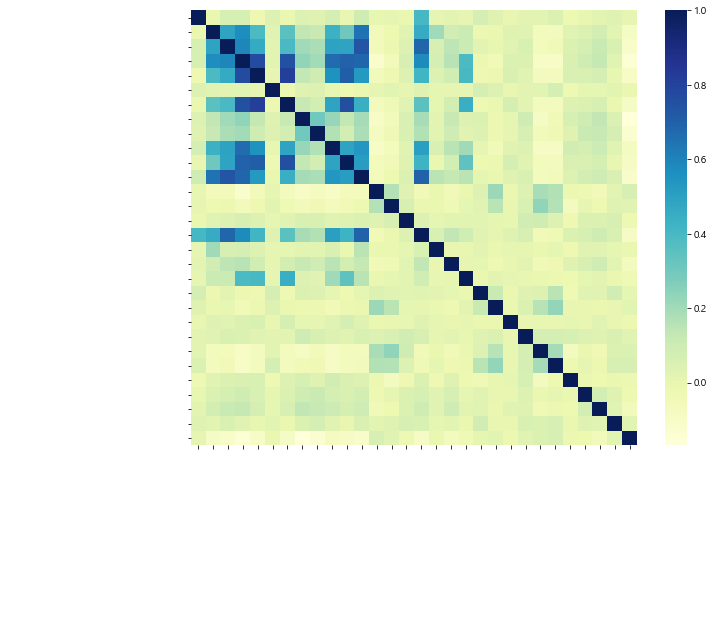

In [12]:
# <히트맵> - 변수 간 상관도를 확인.
# 상관도가 높은 것이 있으나, 변수간 분포가 비슷할 뿐 의미상 다른 변수이므로 잘못된 변수 선택은 아님.
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic') # 한글폰트 설정
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 단위 설정

ax = plt.figure(figsize=(10,8)).add_subplot(111)
### 다크모드라 축색 흰색으로 함
[t.set_color('white') for t in ax.xaxis.get_ticklabels()]
[t.set_color('white') for t in ax.yaxis.get_ticklabels()]
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
###

ax = sns.heatmap(data[feature_new].corr(), cmap='YlGnBu')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

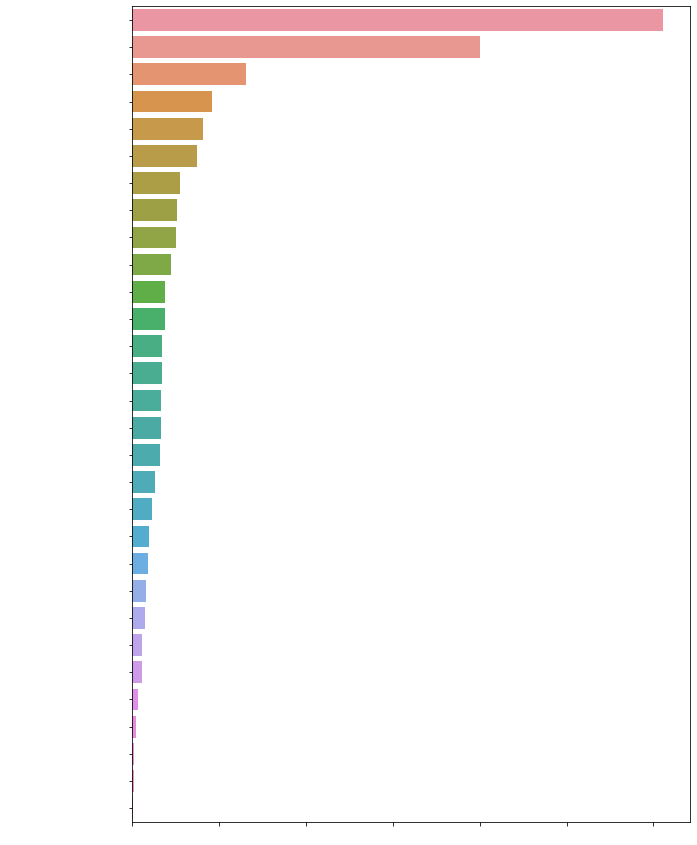

In [13]:
# <변수 중요도 - rf>
import seaborn as sns, matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic') # 한글폰트 설정
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 단위 설정

ft = pd.Series(rf.feature_importances_, index=X1.columns)
top = ft.sort_values(ascending=False)
_, ax = plt.subplots(figsize=(10,15))
### 다크모드라 축색 흰색으로 함
[t.set_color('white') for t in ax.xaxis.get_ticklabels()]
[t.set_color('white') for t in ax.yaxis.get_ticklabels()]
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
###

ax = sns.barplot(x=top, y=top.index)
plt.yticks(fontsize=10)
plt.show()

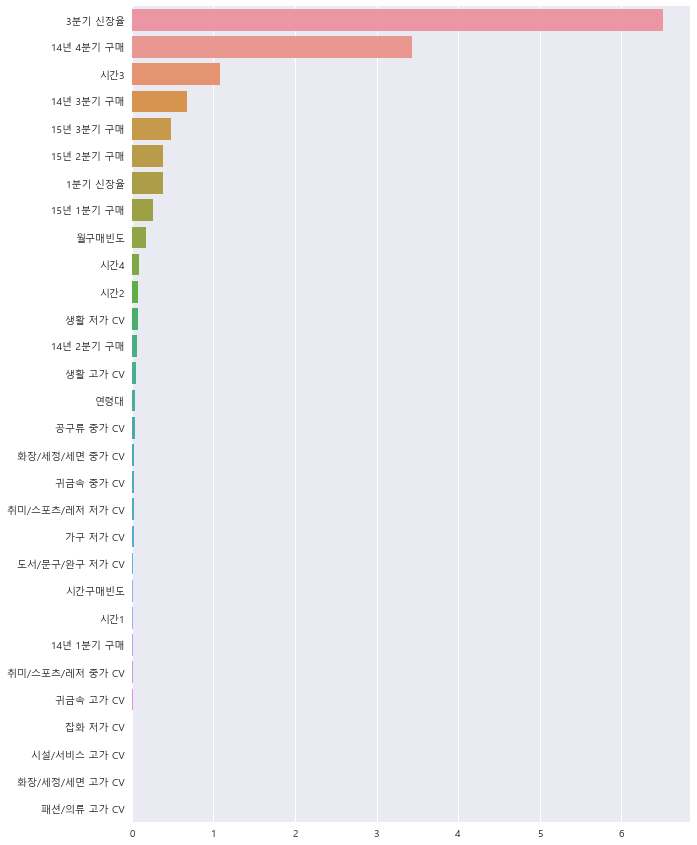

In [ ]:
# <변수 중요도 - lr>
import seaborn as sns, matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic') # 한글폰트 설정
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 단위 설정

ft = pd.Series(lr.coef_.reshape(len(feature_new),), index=X1.columns)
top = ft.abs().sort_values(ascending=False)
_, ax = plt.subplots(figsize=(10,15))

### 다크모드라 축색 흰색으로 함
[t.set_color('white') for t in ax.xaxis.get_ticklabels()]
[t.set_color('white') for t in ax.yaxis.get_ticklabels()]
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
###

ax = sns.barplot(x=top, y=top.index)
plt.yticks(fontsize=10)
plt.show()

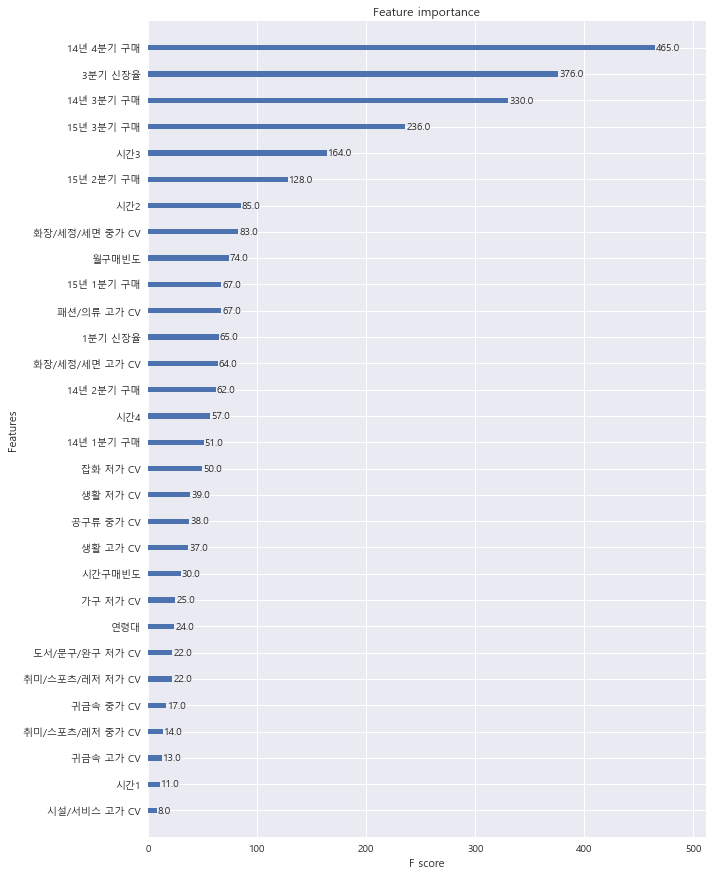

In [ ]:
# <변수 중요도 - xgb>
from xgboost import plot_importance
import seaborn as sns, matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic') # 한글폰트 설정
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 단위 설정

_, ax = plt.subplots(figsize=(10,15))
### 다크모드라 축색 흰색으로 함
[t.set_color('white') for t in ax.xaxis.get_ticklabels()]
[t.set_color('white') for t in ax.yaxis.get_ticklabels()]
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
###

ax = plot_importance(xgb, ax=ax)
plt.yticks(fontsize=10)
plt.show()

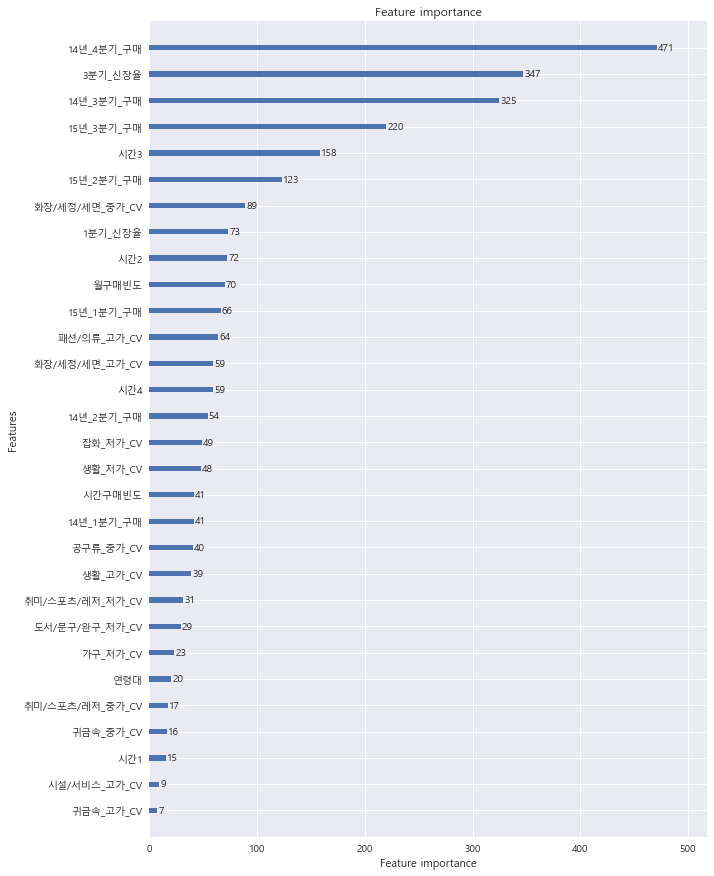

In [ ]:
# <변수 중요도 - lgbm>
import seaborn as sns, matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic') # 한글폰트 설정
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 단위 설정

from lightgbm import plot_importance
_, ax = plt.subplots(figsize=(10,15))
### 다크모드라 축색 흰색으로 함
[t.set_color('white') for t in ax.xaxis.get_ticklabels()]
[t.set_color('white') for t in ax.yaxis.get_ticklabels()]
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
###

ax = plot_importance(lgbm, ax=ax)
plt.yticks(fontsize=10)
plt.show()

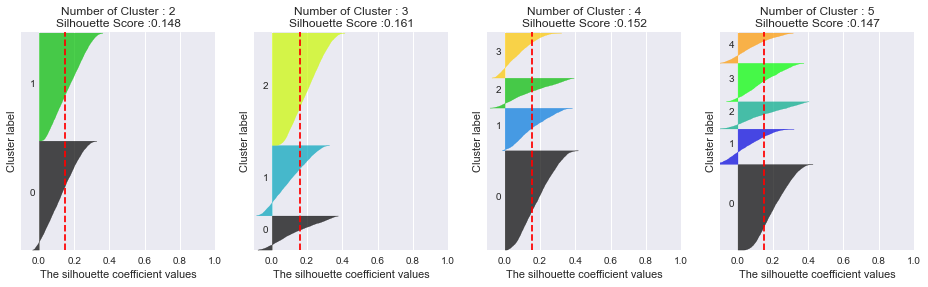

In [ ]:
# <군집화> - KMeans사용.
from sklearn.preprocessing import Normalizer

# 군집 개수에 따른 실루엣 점수를 시각화하는 사용자 함수
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np
    plt.style.use('seaborn')
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")


# <전처리> Normalization - feature 자체의 크기가 반영되지 않도록 함
data_normalized = total_df.copy()
df = data_normalized.drop('label',axis=1)
scale = Normalizer()
df = pd.concat([pd.DataFrame(scale.fit_transform(df), columns=df.columns),
                data_normalized.label], axis=1)
data_normalized = df

# 예측된 label을 붙여 예측된 label들로써 군집화를 진행하도록 함.
# 군집화에 사용되는 feature는 예측과 동일하게 구성.
prediction = xgb.predict(data_scaled[feature_new])
data2 = data_normalized.copy()
data2.label = prediction
data3 = data2.loc[data2.label == 0, feature_new]

# 군집수를 2~5개로 확인해본 결과 3개가 실루엣 점수가 높고 군집별로도 잘 분포되어 있음을 확인
visualize_silhouette([2,3,4,5],data3.values)

C:\Users\chonh\AppData\Local\Temp\ipykernel_19212\581202574.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
C:\Users\chonh\AppData\Local\Temp\ipykernel_19212\581202574.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\


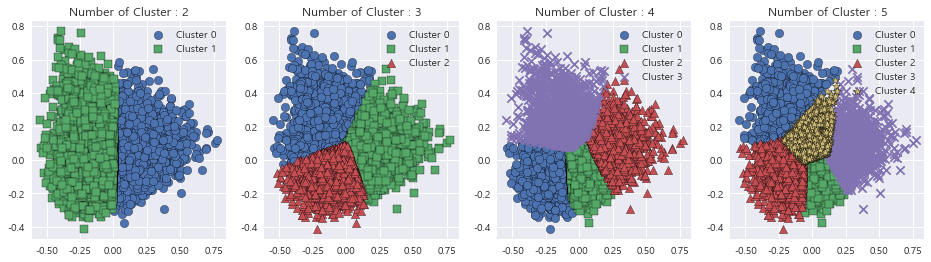

In [ ]:
# 데이터를 2차원 평면에 산점도로 표현하되, 군집별로 나누어 표기하도록 하는 사용자함수
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()
# 위에서 본 것처럼 3개일 때 잘 나뉜 것을 확인할 수 있음.
visualize_kmeans_plot_multi([2,3,4,5],data3.values)

In [ ]:
# 교차검증 - Xgb
# 튜닝은 하지 않았으나 규제를 좀 주어도 나쁘지 않은 정확도가 나옴.
# 검증 후 파라미터로 진행하는 것이 더 정확하나 큰 차이가 없어 보이므로 이번 경우는 그냥 진행 하였음.
from xgboost import cv
import xgboost
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,
        'learning_rate': 0.1, 'max_depth': 4, 'alpha': 100}

data_dmatrix = xgboost.DMatrix(X1,label=y1)
xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=400, 
                early_stopping_rounds=100, metrics="auc", as_pandas=True, seed=4)
xgb_cv[:-2:-1]

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
399,0.833775,0.001613,0.811251,0.002418


In [ ]:
# <클러스터를 합한 분석용 데이터셋 만들기> - 정규화 되어 있는 데이터셋
from sklearn.cluster import KMeans
import numpy as np
clusterer = KMeans(n_clusters = 3, max_iter=500, random_state=0)
cluster_labels = clusterer.fit_predict(data3.values)

data2['cluster'] = np.nan
data2.loc[data2.label == 0, 'cluster'] = cluster_labels

dd = pd.concat([data3, data2['cluster']], axis=1)

dd.to_csv('./dataset/cluster_result.csv', index=False)
dd

,3분기 신장율,14년 4분기 구매,15년 2분기 구매,시간3,14년 3분기 구매,월구매빈도,14년 2분기 구매,생활 고가 CV,패션/의류 고가 CV,시간2,...,시간1,가구 저가 CV,도서/문구/완구 저가 CV,잡화 저가 CV,연령대,시설/서비스 고가 CV,귀금속 중가 CV,화장/세정/세면 고가 CV,시간구매빈도,cluster
0,1.269712e-08,0.709396,0.261307,0.003004,0.327768,3.040081e-08,0.327835,5.198539e-09,1.459239e-08,0.003694,...,0.0,2.401664e-08,0.000000e+00,2.872877e-08,2.736073e-07,0.000000e+00,1.571722e-08,6.171365e-09,4.256113e-07,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.693773e-07,0.343073,0.272264,0.003715,0.563882,6.089551e-06,0.477102,0.000000e+00,0.000000e+00,0.002361,...,0.0,0.000000e+00,0.000000e+00,6.202643e-07,7.829423e-06,0.000000e+00,0.000000e+00,2.174840e-07,1.043923e-05,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.321771e-07,0.362511,0.340275,0.001851,0.388611,9.828081e-07,0.382716,1.097060e-07,6.523389e-08,0.002680,...,0.0,0.000000e+00,1.228510e-07,7.211354e-08,1.105659e-06,6.142551e-08,0.000000e+00,6.633955e-08,1.719914e-06,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18862,3.195046e-08,0.549674,0.149571,0.003207,0.502065,7.797165e-07,0.527462,0.000000e+00,0.000000e+00,0.003932,...,0.0,0.000000e+00,9.648992e-08,9.200655e-08,7.797165e-07,0.000000e+00,0.000000e+00,0.000000e+00,4.483370e-06,1.0
18863,1.374741e-07,0.352524,0.492357,0.002877,0.400435,5.177809e-07,0.480349,0.000000e+00,0.000000e+00,0.002459,...,0.0,6.144333e-08,4.625509e-08,1.102873e-07,6.903745e-07,1.725936e-07,0.000000e+00,1.725936e-07,1.898530e-06,2.0
18864,1.803826e-07,0.543312,0.334609,0.005572,0.291701,8.306972e-07,0.306608,7.328595e-08,8.980760e-08,0.003184,...,0.0,0.000000e+00,0.000000e+00,9.229969e-08,3.691987e-07,0.000000e+00,0.000000e+00,5.657971e-08,1.661394e-06,2.0


In [ ]:
# <클러스터 합친 분석용 데이터셋 만들기> - 인사이트 추출을 위한 정규화 안된 데이터셋
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters = 3, max_iter=500, random_state=0)
cluster_labels = clusterer.fit_predict(data3.values)

data2['cluster'] = np.nan
data2.loc[data2.label == 0, 'cluster'] = cluster_labels

# temp_df = total_df.drop(dropcolumns,axis=1)
temp_df = total_df.drop('label',axis=1)
dd = pd.concat([temp_df[feature_new], data2['cluster']], axis=1)

dd.to_csv('./dataset/cluster_result_ori.csv', index=False)
dd

,3분기 신장율,14년 4분기 구매,15년 2분기 구매,시간3,14년 3분기 구매,월구매빈도,14년 2분기 구매,생활 고가 CV,패션/의류 고가 CV,시간2,...,시간1,가구 저가 CV,도서/문구/완구 저가 CV,잡화 저가 CV,연령대,시설/서비스 고가 CV,귀금속 중가 CV,화장/세정/세면 고가 CV,시간구매빈도,cluster
0,0.417657,23334762,8595380,98828.296078,10781550,1,10783765,0.171,0.480,121515.579268,...,0.0,0.790,0.000,0.945,9,0.0,0.517,0.203,14,0.0
1,1.134392,7080920,9310130,127401.390476,14841180,3,10199760,0.417,0.559,145532.516556,...,0.0,0.203,0.000,0.833,9,0.0,0.000,0.493,13,NaN
2,0.654505,394366,312970,4270.698225,648188,7,548433,0.000,0.000,2713.485981,...,0.0,0.000,0.000,0.713,9,0.0,0.000,0.250,12,1.0
3,0.784777,1823100,1919645,23321.539568,2434410,5,3732463,0.413,0.202,17623.431034,...,0.0,0.000,0.000,0.538,9,0.0,0.000,0.367,14,NaN
4,1.075914,2950816,2769821,15068.534884,3163273,8,3115284,0.893,0.531,21818.818182,...,0.0,0.000,1.000,0.587,9,0.5,0.000,0.540,14,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18861,0.511703,455450,553590,1844.718519,578210,3,913988,0.000,0.000,5544.137931,...,0.0,0.000,0.000,0.000,2,0.0,0.000,0.000,17,NaN
18862,0.163908,2819868,767309,16449.575510,2575628,4,2705917,0.000,0.000,20171.615385,...,0.0,0.000,0.495,0.472,4,0.0,0.000,0.000,23,1.0
18863,0.796519,2042511,2852695,16670.564626,2320105,3,2783122,0.000,0.000,14246.957895,...,0.0,0.356,0.268,0.639,4,1.0,0.000,1.000,11,2.0
18864,1.954314,5886390,3625250,60369.455587,3160370,9,3321870,0.794,0.973,34493.827160,...,0.0,0.000,0.000,1.000,4,0.0,0.000,0.613,18,2.0


In [ ]:
import pandas as pd
cluster_df = pd.read_csv('./dataset/cluster_result.csv')
cluster_df

,3분기 신장율,14년 4분기 구매,15년 2분기 구매,시간3,14년 3분기 구매,월구매빈도,14년 2분기 구매,생활 고가 CV,패션/의류 고가 CV,시간2,...,시간1,가구 저가 CV,도서/문구/완구 저가 CV,잡화 저가 CV,연령대,시설/서비스 고가 CV,귀금속 중가 CV,화장/세정/세면 고가 CV,시간구매빈도,cluster
0,1.269712e-08,0.709396,0.261307,0.003004,0.327768,3.040081e-08,0.327835,5.198539e-09,1.459239e-08,0.003694,...,0.0,2.401664e-08,0.000000e+00,2.872877e-08,2.736073e-07,0.000000e+00,1.571722e-08,6.171365e-09,4.256113e-07,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.693773e-07,0.343073,0.272264,0.003715,0.563882,6.089551e-06,0.477102,0.000000e+00,0.000000e+00,0.002361,...,0.0,0.000000e+00,0.000000e+00,6.202643e-07,7.829423e-06,0.000000e+00,0.000000e+00,2.174840e-07,1.043923e-05,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.321771e-07,0.362511,0.340275,0.001851,0.388611,9.828081e-07,0.382716,1.097060e-07,6.523389e-08,0.002680,...,0.0,0.000000e+00,1.228510e-07,7.211354e-08,1.105659e-06,6.142551e-08,0.000000e+00,6.633955e-08,1.719914e-06,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18862,3.195046e-08,0.549674,0.149571,0.003207,0.502065,7.797165e-07,0.527462,0.000000e+00,0.000000e+00,0.003932,...,0.0,0.000000e+00,9.648992e-08,9.200655e-08,7.797165e-07,0.000000e+00,0.000000e+00,0.000000e+00,4.483370e-06,1.0
18863,1.374741e-07,0.352524,0.492357,0.002877,0.400435,5.177809e-07,0.480349,0.000000e+00,0.000000e+00,0.002459,...,0.0,6.144333e-08,4.625509e-08,1.102873e-07,6.903745e-07,1.725936e-07,0.000000e+00,1.725936e-07,1.898530e-06,2.0
18864,1.803826e-07,0.543312,0.334609,0.005572,0.291701,8.306972e-07,0.306608,7.328595e-08,8.980760e-08,0.003184,...,0.0,0.000000e+00,0.000000e+00,9.229969e-08,3.691987e-07,0.000000e+00,0.000000e+00,5.657971e-08,1.661394e-06,2.0


In [ ]:
cluster_df = cluster_df.dropna()

In [ ]:
# 군집화 기준이 무엇인지 살펴보기 위해 과적합 시켜서 확인해보려 함.
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(random_state=0,max_depth=2)
dt.fit(cluster_df.drop('cluster',axis=1), cluster_df['cluster'])
pred = dt.predict(cluster_df.drop('cluster',axis=1))
print(accuracy_score(cluster_df['cluster'], pred))

0.8034693672916876


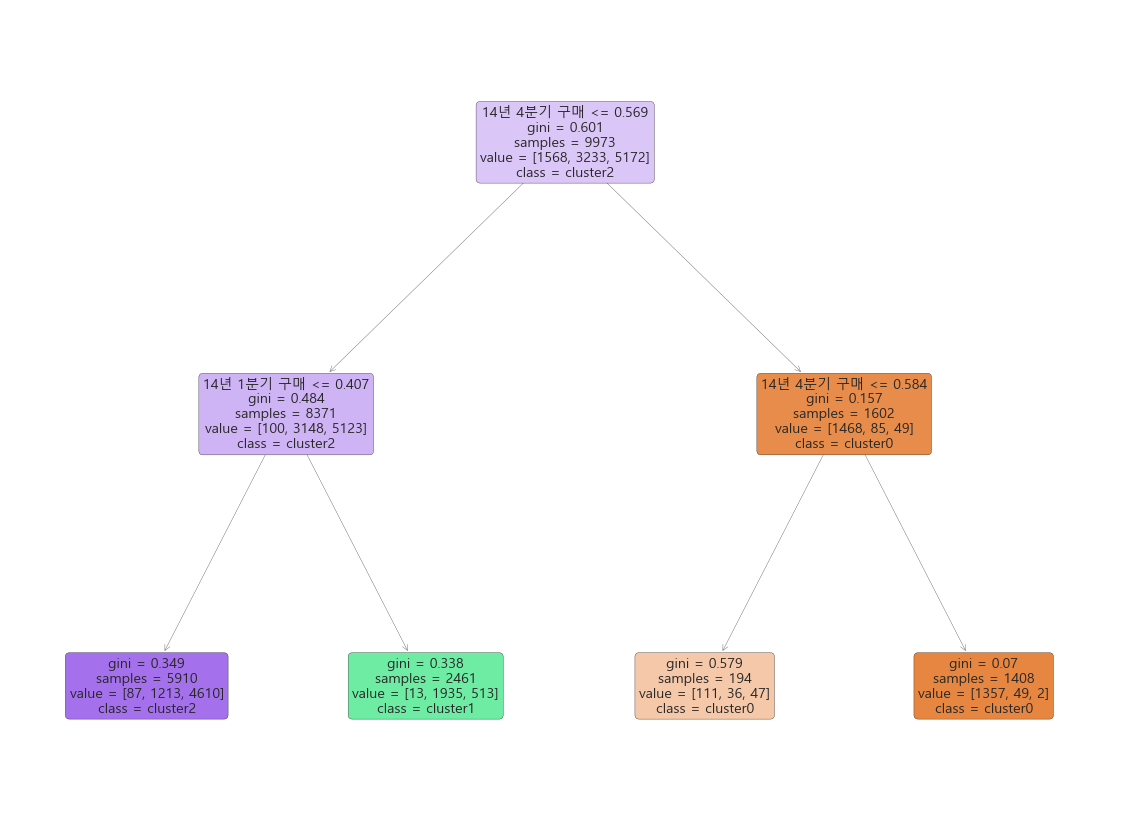

In [ ]:
# 디시즌트리 시각화
# 구매력의 의미를 가진 분기별 구매가 먼저 중요한 지표였음을 알 수 있다.
from sklearn import tree
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',family='Malgun Gothic') # 한글폰트 설정
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 단위 설정

ax = plt.figure(figsize = (20,15)).add_subplot(111)
ax = tree.plot_tree(dt, filled= True,
                feature_names= cluster_df.columns.tolist()[:-1],
                class_names= ['cluster0','cluster1','cluster2'],
                rounded=True,fontsize=14)
plt.show()
plt.close()

In [4]:
# 이제 진짜 인사이트 도출을 위한 데이터셋 가져옴
import pandas as pd
cluster_df_ori = pd.read_csv('./dataset/cluster_result_ori.csv')
cluster_df_ori

,3분기 신장율,14년 4분기 구매,15년 2분기 구매,시간3,14년 3분기 구매,월구매빈도,14년 2분기 구매,생활 고가 CV,패션/의류 고가 CV,시간2,...,시간1,가구 저가 CV,도서/문구/완구 저가 CV,잡화 저가 CV,연령대,시설/서비스 고가 CV,귀금속 중가 CV,화장/세정/세면 고가 CV,시간구매빈도,cluster
0,0.417657,23334762,8595380,98828.296078,10781550,1,10783765,0.171,0.480,121515.579268,...,0.0,0.790,0.000,0.945,9,0.0,0.517,0.203,14,0.0
1,1.134392,7080920,9310130,127401.390476,14841180,3,10199760,0.417,0.559,145532.516556,...,0.0,0.203,0.000,0.833,9,0.0,0.000,0.493,13,NaN
2,0.654505,394366,312970,4270.698225,648188,7,548433,0.000,0.000,2713.485981,...,0.0,0.000,0.000,0.713,9,0.0,0.000,0.250,12,1.0
3,0.784777,1823100,1919645,23321.539568,2434410,5,3732463,0.413,0.202,17623.431034,...,0.0,0.000,0.000,0.538,9,0.0,0.000,0.367,14,NaN
4,1.075914,2950816,2769821,15068.534884,3163273,8,3115284,0.893,0.531,21818.818182,...,0.0,0.000,1.000,0.587,9,0.5,0.000,0.540,14,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18861,0.511703,455450,553590,1844.718519,578210,3,913988,0.000,0.000,5544.137931,...,0.0,0.000,0.000,0.000,2,0.0,0.000,0.000,17,NaN
18862,0.163908,2819868,767309,16449.575510,2575628,4,2705917,0.000,0.000,20171.615385,...,0.0,0.000,0.495,0.472,4,0.0,0.000,0.000,23,1.0
18863,0.796519,2042511,2852695,16670.564626,2320105,3,2783122,0.000,0.000,14246.957895,...,0.0,0.356,0.268,0.639,4,1.0,0.000,1.000,11,2.0
18864,1.954314,5886390,3625250,60369.455587,3160370,9,3321870,0.794,0.973,34493.827160,...,0.0,0.000,0.000,1.000,4,0.0,0.000,0.613,18,2.0


In [5]:
cluster_df = cluster_df_ori.dropna()

In [6]:
cluster_df.head()

,3분기 신장율,14년 4분기 구매,15년 2분기 구매,시간3,14년 3분기 구매,월구매빈도,14년 2분기 구매,생활 고가 CV,패션/의류 고가 CV,시간2,...,시간1,가구 저가 CV,도서/문구/완구 저가 CV,잡화 저가 CV,연령대,시설/서비스 고가 CV,귀금속 중가 CV,화장/세정/세면 고가 CV,시간구매빈도,cluster
0,0.417657,23334762,8595380,98828.296078,10781550,1,10783765,0.171,0.480,121515.579268,...,0.0,0.790,0.000,0.945,9,0.0,0.517,0.203,14,0.0
2,0.654505,394366,312970,4270.698225,648188,7,548433,0.000,0.000,2713.485981,...,0.0,0.000,0.000,0.713,9,0.0,0.000,0.250,12,1.0
4,1.075914,2950816,2769821,15068.534884,3163273,8,3115284,0.893,0.531,21818.818182,...,0.0,0.000,1.000,0.587,9,0.5,0.000,0.540,14,2.0
5,0.559435,16221723,11888419,125106.740413,4711569,1,2842322,0.716,0.564,81996.647399,...,0.0,0.378,0.384,0.823,9,0.0,0.000,0.707,20,0.0
6,0.976711,11151680,7412510,49640.322684,6999500,8,5264270,1.000,0.096,117144.494382,...,0.0,0.000,0.000,1.000,9,0.0,1.000,0.433,15,2.0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X_train, X_test, y_train, y_test = train_test_split(cluster_df, cluster_df['label'], test_size=0.3, random_state=0)

dt = DecisionTreeClassifier(random_state=0,max_depth=2)
dt.fit(cluster_df[cluster_df.columns[:30].tolist()], cluster_df['cluster'])
pred = dt.predict(cluster_df[cluster_df.columns[:30].tolist()])
print(accuracy_score(cluster_df['cluster'], pred))

0.6703098365587085


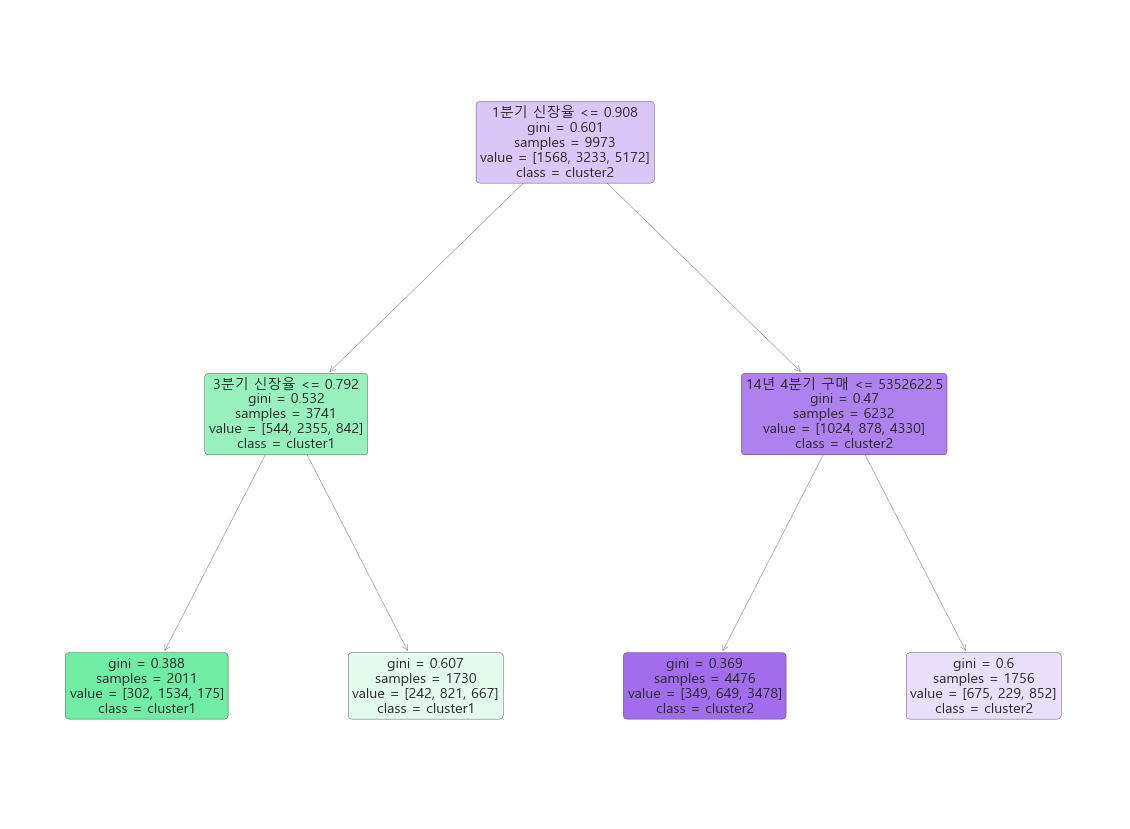

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Malgun Gothic') # 한글폰트 설정
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 단위 설정

ax = plt.figure(figsize = (20,15)).add_subplot(111)
ax = tree.plot_tree(dt, filled= True,
                feature_names= cluster_df.columns[:30].tolist(),
                class_names= ['cluster0','cluster1','cluster2'],
                rounded=True,fontsize=14)
plt.show()
plt.close()

In [7]:
# 비유의고객을 9로 채움
cluster_df = cluster_df_ori.fillna(9)

## 이 밑에서 보면서 인사이트를 도출


In [8]:
cluster_df.groupby('cluster')[cluster_df.columns.tolist()[:15]].mean()

,3분기 신장율,14년 4분기 구매,15년 2분기 구매,시간3,14년 3분기 구매,월구매빈도,14년 2분기 구매,생활 고가 CV,패션/의류 고가 CV,시간2,14년 1분기 구매,15년 1분기 구매,공구류 중가 CV,취미/스포츠/레저 저가 CV,취미/스포츠/레저 중가 CV
cluster,,,,,,,,,,,,,,,
0.0,0.927222,1.458428e+07,5.631876e+06,71896.236219,5.280037e+06,7.191327,5.501029e+06,0.374398,0.428226,127944.793996,4.853058e+06,6.339506e+06,0.242307,0.350378,0.282191
1.0,0.677321,4.950977e+06,3.159461e+06,43712.779017,4.974262e+06,5.386638,5.971808e+06,0.202591,0.233615,68341.115761,5.882187e+06,3.658400e+06,0.255737,0.334223,0.244614
2.0,0.989184,4.283961e+06,4.112824e+06,33359.008808,3.371519e+06,6.318639,3.067947e+06,0.222381,0.318148,53472.570795,2.766348e+06,4.132089e+06,0.327226,0.426963,0.301698
9.0,2.009329,3.857291e+06,4.860525e+06,46593.808325,3.637286e+06,6.925222,4.067029e+06,0.282509,0.356548,78092.449824,4.105407e+06,4.508639e+06,0.312765,0.401298,0.296411


In [9]:
cluster_df.groupby('cluster')[cluster_df.columns.tolist()[15:-1]].mean()

,15년 3분기 구매,1분기 신장율,귀금속 고가 CV,시간4,화장/세정/세면 중가 CV,생활 저가 CV,시간1,가구 저가 CV,도서/문구/완구 저가 CV,잡화 저가 CV,연령대,시설/서비스 고가 CV,귀금속 중가 CV,화장/세정/세면 고가 CV,시간구매빈도
cluster,,,,,,,,,,,,,,,
0.0,4.842791e+06,9.011708,0.052691,32472.392463,0.486249,0.343545,5156.868297,0.278270,0.227430,0.537240,5.565051,0.118068,0.098233,0.501156,16.725128
1.0,2.740125e+06,0.822717,0.023808,28609.070332,0.398558,0.320241,4093.045721,0.223086,0.234486,0.501648,5.643675,0.086558,0.062130,0.408888,17.109805
2.0,3.440795e+06,2.290352,0.026974,23296.181081,0.477319,0.380790,3120.577709,0.288964,0.307773,0.585073,5.623937,0.106418,0.067372,0.498747,17.450503
9.0,4.912684e+06,2.253645,0.040541,24191.251805,0.500273,0.392559,2815.157842,0.286853,0.289251,0.591105,5.623861,0.115374,0.081460,0.508916,17.336219


In [ ]:
# 1분기 신장율에 대해 9는 이상치인 것 같아 해당 항 3개를 제거하고 평균 뽑아봄
cluster_df.loc[cluster_df.cluster == 0,'1분기 신장율'].sort_values(ascending=False)[3:].mean()

2.770702098709637

개인화된 상품 추천 시스템
- 인사이트 도출된 것 중에서 상품 기반 정보는 추천시스템에 적용하여 알맞은 솔루션으로써 활용할 수 있다.
- 방법적인 것과 구매지수의 정의는 ppt 참고


In [ ]:
# 예시로 들 고객번호를 보기 위한 셀임.
# 군집1의 22번 고객을 예시로 들어보려고 한다.
import pandas as pd
cluster_df = pd.read_csv('./dataset/cluster_result.csv')
df = pd.read_pickle('./dataset/PP_CUS_QUAR_NORMAL.pkl') # 지속고객으로 정의한 18865명의 고객번호가 있는 테이블 아무거나 사용
import_df = pd.concat([df['고객번호'], cluster_df['cluster']], axis=1)
import_df = import_df.fillna(9)
import_df.cluster = import_df.cluster.astype('int')
# import_df.to_csv('./dataset/import_customer.csv', index=False)
import_df

,고객번호,cluster
0,00001,0
1,00002,9
2,00003,1
3,00004,9
4,00006,2
...,...,...
18861,19333,9
18862,19334,1
18863,19335,2
18864,19336,2


In [ ]:
# 모든 과정은 사용자 함수로 정의하여 고객번호, 중분류 list, date를 입력받으면 작동하도록 구성한다.


# 입력받은 중분류가 많을 것을 대비하여 리스트 중에서 구매지수가 높은 것 n개 뽑고, 그것들로 추천리스트를 적용하게 된다.
def get_prodcl_list(target_id = None,prodcl_list=None,n = 3,date = None):
    import cx_Oracle
    import pandas as pd
    import numpy as np
    con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
    cursor = con.cursor()
    
    cursor.execute(f"SELECT 구분2, COUNT(CASE WHEN 구매일자 < {date} THEN 구매금액 END) 중분류별구매건수, SUM(CASE WHEN 구매일자 < {date} THEN 구매금액 END) 중분류별구매총액 FROM PURPROD,PRODCL_RENEW WHERE PURPROD.소분류코드 = PRODCL_RENEW.소분류코드 AND 고객번호 = {target_id} AND 구분2 IN{tuple(prodcl_list)} GROUP BY 구분2 ORDER BY 구분2")
    x = cursor.fetchall()
    col = ['중분류명','중분류별구매건수','중분류별구매총액']
    df = pd.DataFrame(x,columns=col)
    df.중분류별구매건수.replace(0,np.nan,inplace=True)

    df['평균단가'] = df['중분류별구매총액'] / df['중분류별구매건수']
    meanprice = df['평균단가'].mean()
    df['단가가중치'] = df['평균단가'].apply(lambda x: x/meanprice)
    df['중분류별구매건수'] = df['중분류별구매건수'] * df['단가가중치']
    df.drop(['평균단가','단가가중치'],axis=1,inplace=True)
    
    df['총구매건수'] = df['중분류별구매건수'].sum()
    df.총구매건수 = df.총구매건수.replace(0,np.nan)
    
    # 최대값은 10으로 준다.
    df['중분류별구매비율'] = df.중분류별구매건수 * 10 / df.총구매건수
    df = df.drop(['중분류별구매건수','중분류별구매총액','총구매건수'],axis=1)
    df = df.sort_values(by='중분류별구매비율',ascending=False)
    high_list = df.중분류명.tolist()
    return high_list[:n]

# 중분류코드와 중분류명을 가져오는 함수
def get_scode(prodcl_list=None):
    import cx_Oracle
    import pandas as pd
    
    con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
    cursor = con.cursor()
    cursor.execute(f"SELECT 구분2,소분류코드,소분류명 FROM PRODCL_RENEW WHERE 구분2 IN {tuple(prodcl_list)} ORDER BY 구분2, 소분류코드")
    x = cursor.fetchall()
    col = ['중분류명','iid','소분류명']
    df = pd.DataFrame(x,columns=col)
    return df

# 실제 사용할 데이터셋을 가져오는 함수
def get_data(target_id = None,prodcl_list=None,date = 20151001):
    import cx_Oracle
    import pandas as pd
    import numpy as np

    con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
    cursor = con.cursor()
    cursor.execute(f"CREATE VIEW TEMP1 AS SELECT 구분2, 소분류코드 FROM PRODCL_RENEW WHERE 구분2 IN {tuple(prodcl_list)}")
    cursor.execute(f"CREATE VIEW TEMP2 AS SELECT 고객번호, PURPROD.소분류코드, COUNT(CASE WHEN 구매일자 < {date} THEN 구매금액 END) 상품별구매건수, SUM(CASE WHEN 구매일자 < {date} THEN 구매금액 END) 상품별구매총액 FROM PURPROD, PRODCL_RENEW WHERE PURPROD.소분류코드 = PRODCL_RENEW.소분류코드 AND 구분2 IN {tuple(prodcl_list)} AND 고객번호 = {target_id} GROUP BY PURPROD.고객번호, PURPROD.소분류코드 ORDER BY PURPROD.고객번호, PURPROD.소분류코드")
    cursor.execute(f"SELECT NVL(고객번호,{target_id}) 고객번호, TEMP1.소분류코드, 상품별구매건수, 상품별구매총액 FROM TEMP2 RIGHT OUTER JOIN TEMP1 ON TEMP2.소분류코드 = TEMP1.소분류코드 ORDER BY 고객번호, TEMP2.소분류코드")
    t = cursor.fetchall()
    col = ['고객번호','소분류코드','상품별구매건수','상품별구매총액']
    df1 = pd.DataFrame(t,columns=col)
    df1['상품별구매건수'] = df1['상품별구매건수'].replace(0,np.nan)

    cursor.execute(f"SELECT 고객번호, PURPROD.소분류코드, COUNT(CASE WHEN 구매일자 < {date} THEN 구매금액 END) 상품별구매건수, SUM(CASE WHEN 구매일자 < {date} THEN 구매금액 END) 상품별구매총액 FROM PURPROD,PRODCL_RENEW WHERE PURPROD.소분류코드 = PRODCL_RENEW.소분류코드 AND 구분2 IN {tuple(prodcl_list)} AND 고객번호 <> {target_id} GROUP BY PURPROD.고객번호, PURPROD.소분류코드 ORDER BY PURPROD.고객번호, PURPROD.소분류코드")
    x = cursor.fetchall()
    col = ['고객번호','소분류코드','상품별구매건수','상품별구매총액']
    df = pd.DataFrame(x,columns=col)
    df = df.dropna()

    cursor.execute(f"DROP VIEW TEMP1")
    cursor.execute(f"DROP VIEW TEMP2")

    # 구매지수로 정의한 것을 만들기 위한 과정. 단가 > 단가가중치 > 가중치가 적용된 건수
    df = pd.concat([df1,df],axis=0).reset_index().drop('index',axis=1)
    df['상품별단가'] = df['상품별구매총액'] / df['상품별구매건수']
    meanprice = df['상품별단가'].mean()
    df['단가가중치'] = df['상품별단가'].apply(lambda x: x/meanprice)
    df['상품별구매건수'] = df['상품별구매건수'] * df['단가가중치']
    df.drop(['상품별단가','단가가중치'],axis=1,inplace=True)
    
    tdf = pd.DataFrame(df.groupby('고객번호')['상품별구매건수'].sum())
    tdf = tdf.reset_index()
    mdf = pd.merge(df,tdf,on='고객번호')
    mdf.columns =['고객번호','소분류코드','상품별구매건수','상품별구매총액','총구매건수']
    mdf.총구매건수 = mdf.총구매건수.replace(0,np.nan)
    
    # 최대값은 10으로 준다.
    mdf['상품별구매비율'] = mdf.상품별구매건수 * 10 / mdf.총구매건수
    mdf = mdf.drop(['상품별구매건수','상품별구매총액','총구매건수'],axis=1)
    return mdf

# 작년 동월의 인기상품 list를 가져오기 전에 입력받은 날짜로부터 해당 기간을 뽑아오기 위한 사용자 함수
def get_between_day(date):
    import datetime
    from datetime import timedelta
    date = datetime.datetime.strptime(date, '%Y%m%d')
    year = date.year - 1
    month = date.month
    next_month = month + 1
    last_month_day = (datetime.date(year, month, 1) - timedelta(1)).strftime('%Y%m%d')
    if next_month == 13:
        next_month = 13
        year = year + 1
    next_month_day = (datetime.date(year, next_month, 1)).strftime('%Y%m%d')
    return last_month_day, next_month_day

# 작년 해당 월에 인기 많은 상품을 추출하기 위하여 추천하려는 달의 데이터를 다시 뽑아온다.
def past_data(prodcl_list=None,date1 = 20140930, date2 = 20141101):
    import cx_Oracle
    import pandas as pd
    
    con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
    cursor = con.cursor()
    cursor.execute(f"SELECT 구분2, PURPROD.소분류코드, COUNT(CASE WHEN 구매일자 between {date1} and {date2} THEN 구매금액 END) 상품별구매건수, SUM(CASE WHEN 구매일자 between {date1} and {date2} THEN 구매금액 END) 상품별구매총액 FROM PURPROD,PRODCL_RENEW WHERE PURPROD.소분류코드 = PRODCL_RENEW.소분류코드 AND 구분2 IN{tuple(prodcl_list)} GROUP BY 구분2, PURPROD.소분류코드 ORDER BY 구분2, PURPROD.소분류코드")
    x = cursor.fetchall()
    col = ['중분류명','소분류코드','상품별구매건수','상품별구매총액']
    df = pd.DataFrame(x,columns=col)
    df = df.dropna()

    df['평균단가'] = df['상품별구매총액'] / df['상품별구매건수'] # 단가 계산
    meanprice = df['평균단가'].mean()
    df['단가가중치'] = df['평균단가'].apply(lambda x: x/meanprice) # 단가를 단가 평균으로 나눠주면 가중치가 나온다
    df['상품별구매건수'] = df['상품별구매건수'] * df['단가가중치'] # 건수에 가중치를 곱해준 것으로 새로운 건수를 만든다
    df.drop(['평균단가','단가가중치'],axis=1,inplace=True)

    tdf = pd.DataFrame(df.groupby('중분류명')['상품별구매건수'].sum()) # 새로운건수의 총합을 중분류별로 구함
    tdf = tdf.reset_index()
    mdf = pd.merge(df,tdf,on='중분류명')
    mdf.columns =['중분류명','소분류코드','상품별구매건수','상품별구매총액','총구매건수']
    mdf['상품별구매비율'] = mdf.상품별구매건수 * 10 / mdf.총구매건수
    
    mdf = mdf.drop(['상품별구매건수','상품별구매총액','총구매건수'],axis=1)
    return mdf

# surprise api 이용을 위해 데이터셋 구성하는 사용자 함수.
def convert_traintest_dataframe_forsurprise(uid = None, dataframe = None):
    from surprise import Reader
    from surprise import Dataset

    data = dataframe[dataframe.상품별구매비율.isnull() == False]
    target_data = dataframe[(dataframe.고객번호 == uid)]

    # 데이터셋을 train과 test로 나누기 위해 섞어준다.
    data = data.sample(frac=1,random_state=0)
    cutoff = int(.80 * len(data))
    train_data = data[:cutoff]
    test_data = data[cutoff:]

    # 최고점은 10점이므로 다음과 같이 구성하였다.
    reader = Reader(rating_scale=(0.001, 10))
    trainset = Dataset.load_from_df(train_data[['고객번호', '소분류코드', '상품별구매비율']], reader)
    testset = Dataset.load_from_df(test_data[['고객번호', '소분류코드', '상품별구매비율']], reader)
    targetset = Dataset.load_from_df(target_data[['고객번호', '소분류코드', '상품별구매비율']], reader)
    
    trainset = trainset.construct_trainset(trainset.raw_ratings)
    testset = testset.construct_testset(testset.raw_ratings)

    targetset = targetset.construct_testset(targetset.raw_ratings)
    
    return trainset, testset, targetset

# Knn-baseline 모델 
def knn_item_based_recommendation(uid = None, trainset = None, testset = None):
    from surprise.prediction_algorithms import KNNBaseline
    from surprise import accuracy
    from surprise import dump
    import pandas as pd
    
    sim_options = {'name': 'cosine',
                'user_based': False  # content(item)-based similarity
                }
    bsl_options = {'method': 'sgd'}

    knnbaseline_algo_i = KNNBaseline(sim_options=sim_options,bsl_options=bsl_options)
    knnbaseline_algo_i.fit(trainset)
    knnbaseline_i_pred = knnbaseline_algo_i.test(testset)
    file_name = f'./dataset/KnnBaseline_model_i_{uid}'
    dump.dump(file_name, predictions=knnbaseline_i_pred, algo=knnbaseline_algo_i)
    
    knn_rmse = accuracy.rmse(knnbaseline_i_pred)
    
    return knn_rmse

# SVD
def svd_recommendation(uid = None, trainset = None, testset = None):
    from surprise import accuracy
    from surprise import dump
    from surprise import SVD
    import pandas as pd

    svd_algo = SVD()

    svd_algo.fit(trainset)
    svd_pred = svd_algo.test(testset)
    file_name = f'./dataset/svd_model_{uid}'
    dump.dump(file_name, predictions = svd_pred, algo=svd_algo)

    svd_rmse = accuracy.rmse(svd_pred)
    return svd_rmse

# 구성된 필터링 알고리즘 중에서 최적의 알고리즘을 선택하고 그것을 이용하여 추천된 상품을 출력하는 함수.
def best_algorism_result(uid = None, targetset = None):
    import pandas as pd
    from surprise import dump

    if knn_rmse > svd_rmse:
        print("SVD의 RMSE가 Knn Baseline의 RMSE보다 낮아 SVD 기반 추천 시스템을 적용합니다.")
        _, loaded_algo = dump.load(f'./dataset/svd_model_{uid}')
    else:
        print("Knn Baseline의 RMSE가 SVD의 RMSE보다 낮아 KNN 기반 추천 시스템을 적용합니다.")
        _, loaded_algo = dump.load(f'./dataset/KnnBaseline_model_i_{uid}')

    target_pred = loaded_algo.test(targetset)
    result = pd.DataFrame(target_pred)
    result = result.drop('details',axis=1).sort_values('est',ascending=False)
    result = result.merge(prodcl_scode,on='iid')
    return result

# 인기상품을 적용하지 않은 Base 상품 추천 시스템
def main(target_id=None, uid=None, prodcl_list_ori = None, date=None):
    global prodcl_list ; prodcl_list = get_prodcl_list(target_id=target_id, prodcl_list=prodcl_list_ori, date = date)
    global prodcl_scode ; prodcl_scode = get_scode(prodcl_list)
    data = get_data(target_id=target_id,prodcl_list=prodcl_list)
    trainset, testset, targetset = convert_traintest_dataframe_forsurprise(uid,data)
    global knn_rmse ; knn_rmse = knn_item_based_recommendation(uid,trainset,testset)
    global svd_rmse ; svd_rmse = svd_recommendation(uid,trainset,testset)
    result = best_algorism_result(uid, targetset)
    return result

# 인기상품도 적용한 Additional 상품 추천 시스템
def main_contain_bestseller(target_id=None, uid=None, prodcl_list_ori=None, date=None):
    result = main(target_id=target_id, uid=uid, prodcl_list_ori=prodcl_list_ori, date=date)
    date1, date2 = get_between_day(str(date))
    past = past_data(prodcl_list,date1,date2)
    past.columns = ['중분류명','iid','r_ui']
    past = past.merge(prodcl_scode.drop('중분류명',axis=1),on='iid')

    result_new = result.copy()
    for i in prodcl_list:
        iid_li = past.iid[past.중분류명 == i][:10].tolist()
        for j in iid_li:
            result_new.loc[result_new.iid == j,'est'] = result_new.loc[result_new.iid == j,'est'] * 1.5
    result_new = result_new.sort_values('est',ascending=False)
    return result_new


In [ ]:
# <실제 적용 예시>
# 타겟 정의 - 1번군집의 22번 고객을 예시로 들어보겠다.

# 파이썬에서 uid를 사용할 때에는 '고객번호'와 같은 형태가 필요하여 변환해줌.
def change_target_id(target_id):
    target_id = target_id.replace("'","")
    uid = target_id.replace('"','')
    return uid

target_id = "'00022'"
uid = change_target_id(target_id)
prodcl_list=['패션/의류 고가','생활 고가','가구 저가']
date = 20151001

In [ ]:
# 이 예시는 47초 걸렸음.
result = main(target_id=target_id, uid=uid, prodcl_list_ori=prodcl_list, date=date)
display(result)

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.2003
RMSE: 1.9871
SVD의 RMSE가 Knn Baseline의 RMSE보다 낮아 SVD 기반 추천 시스템을 적용합니다.


,uid,iid,r_ui,est,중분류명,소분류명
0,00022,B410102,NaN,8.030208,생활 고가,압력밥솥
1,00022,A060202,8.552832,7.778189,패션/의류 고가,L/C골프의류
2,00022,B860301,NaN,6.314499,생활 고가,프리미엄다용도매트
3,00022,A020601,NaN,6.254804,패션/의류 고가,네셔널
4,00022,B200203,NaN,5.092108,생활 고가,온라인 음식조리
...,...,...,...,...,...,...
109,00022,A040307,NaN,1.130024,패션/의류 고가,안토니모라토 상품군
110,00022,A090406,NaN,1.102616,생활 고가,식기단기행사
111,00022,A050111,NaN,1.080168,패션/의류 고가,니나리찌
112,00022,A090401,NaN,1.061913,생활 고가,크리스탈


In [ ]:
# 이 예시는 1분 걸렸음
# 위 추천리스트와 비교하면 인기상품이었던 것들이 가중치가 적용되어 위쪽으로 올라온 것을 볼 수 있다.
result_new = main_contain_bestseller(target_id=target_id, uid=uid, prodcl_list_ori=prodcl_list, date=date)
display(result_new)

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.2003
RMSE: 1.9787
SVD의 RMSE가 Knn Baseline의 RMSE보다 낮아 SVD 기반 추천 시스템을 적용합니다.


,uid,iid,r_ui,est,중분류명,소분류명
2,00022,A020601,NaN,10.428669,패션/의류 고가,네셔널
0,00022,A060202,8.552832,7.762377,패션/의류 고가,L/C골프의류
1,00022,B410102,NaN,7.458132,생활 고가,압력밥솥
5,00022,A040222,NaN,7.185191,패션/의류 고가,영 캐릭터
7,00022,A040212,NaN,6.380233,패션/의류 고가,수입브릿지
...,...,...,...,...,...,...
107,00022,A050102,NaN,1.191324,패션/의류 고가,직수입정장
108,00022,A040307,NaN,1.152865,패션/의류 고가,안토니모라토 상품군
110,00022,A040232,NaN,1.068648,패션/의류 고가,프리미엄진
113,00022,A090306,NaN,1.029838,생활 고가,매트
